In [ ]:
# transfer learning from resnet18 for vowel prediction by mouth shape

In [13]:
# パッケージ読み込み
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [14]:
# データの読み込み

# データ前処理の定義
# 画像データの前処理に関しては
# http://iwiwi.hatenadiary.jp/entry/2016/12/31/162059

# ディクショナリ"data_transforms"を生成する
# trainとvalにそれぞれ異なるtransformsを格納
data_transforms = {
    'train' : transforms.Compose([
        #transforms.RandomResizedCrop(256), #224*224のサイズで画像をランダムな位置から抽出する
        transforms.RandomHorizontalFlip(), #画像を水平方向に反転する
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256), #画像を256*256にリサイズする
        #transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

# データ読み込みディレクトリを定義
# dataloaderなどの詳細は下記URLを参照
# https://qiita.com/takurooo/items/e4c91c5d78059f92e76d
# https://qiita.com/takurooo/items/ba8c509eaab080e2752c

# データのディレクトリを設定
data_dir = './mouth_data'

# 内包表記を使ってキーがtrain,valのディクショナリを生成する
# 指定したディレクトリの画像データに対し、定義したtransformsを適用して保持する
# 内包表記のxはin ['train', 'val'] で繰り返し実施
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# dataloaderの定義
# train, valそれぞれに対してバッチサイズ4、シャッフルありで作成
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
# データセットのサイズを取得
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# データのクラスを生成
class_names = image_datasets['train'].classes

# GPUの設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

4 torch.Size([4, 3, 256, 256])


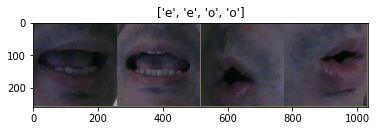

tensor([1, 1, 3, 3])
['a', 'e', 'i', 'o', 'u']


In [15]:
# 読み込んだ画像を表示する

# 読み込み関数を定義
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0)) # 入力のテンソルをnumpy形式に変換してC*H*Wの並びからH*W*Cの並びに変換する
    mean = np.array([0.485,0.456,0.406]) # 後で標準化したデータをもとに戻すために使う平均値を格納
    std = np.array([0.229,0.224,0.225]) # 後で標準化したデータをもとに戻すために使う標準偏差を格納
    inp = std * inp + mean # 標準化したデータをもとに戻す
    inp = np.clip(inp, 0, 1) # 最小0、最大1の範囲にデータを収める https://note.nkmk.me/python-numpy-clip/
    plt.imshow(inp) # matplotlibで画像を表示　http://pynote.hatenablog.com/entry/matplotlib-imshow
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# dataloaderをイテレータオブジェクトにしてnextの要素を格納する
inputs, classes = next(iter(dataloaders['train'])) #https://algorithm.joho.info/programming/python/iter-next-py/

# inputs画像を使ってグリッドを生成する
out = torchvision.utils.make_grid(inputs) # https://blog.shikoan.com/torchvision-image-tile/
print(len(inputs),
     inputs.size())

imshow(out, title=[class_names[x] for x in classes])
print(classes)
print(class_names)

In [4]:
# モデルの訓練を実施
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #開始時を取得
    
    best_model_wts = copy.deepcopy(model.state_dict()) # 引数にとったモデルの重みをbest_model_wtsにディープコピーする
    best_acc = 0.0 # 精度を0にリセット
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1)) # 現在のepochを表示
        print('-'*10) # ハイフンを10個表示
        for phase in ['train','val']: # trainとvalを交互に繰り返していく
            if phase == 'train':
                model.train() # モデルをトレーニングモードにする
            if phase == 'val':
                model.eval() # モデルを評価モードにする
            running_loss = 0.0 # 累積損失をリセット
            running_corrects = 0.0 # 累積正答数をリセット
            
            for inputs, labels in dataloaders[phase]: # バッチ毎に繰り返し
                # cudaがあればinputs,labelsをGPU用に変換
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad() # 勾配をゼロにリセット
                
                with torch.set_grad_enabled(phase == 'train'): #トレーニングモードならばautogradをオンにする
                    outputs = model(inputs) # モデルに入力データを通して出力を得る
                    _, preds = torch.max(outputs, 1) # 出力されたスコアが最大であるインデックスをバッチごとに取得
                    loss = criterion(outputs, labels) # 定義したcriterionで損失を出力
                    
                    if phase == 'train': # トレーニングモードの場合、逆伝播を行って重みを更新する
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() # 学習率を変化させる
            
            # epochでの平均損失、平均精度を出力
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # バリデーションデータによる精度がこれまでの最高精度よりも良ければ
            # 最高精度を更新し、モデルの重みも最高精度のものに更新する
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # 全epochが終了したら、best modelの重みを読み込んでmodelを戻り値で返す
    model.load_state_dict(best_model_wts)
    return model

In [78]:
# モデルによる予測を可視化する
def visualize_model(model, num_images=6):
    was_training = model.training # モデルが訓練されているかどうかをTrue or Falseで返す
    model.eval() # 評価モード
    images_so_far = 0 # subplotに表示する際の、何番目の画像かを示す変数
    fig = plt.figure()
    
    with torch.no_grad(): #autogradをオフにして推論を実施
        for i, (inputs, labels) in enumerate(dataloaders['val']): #dataloaderのキーがvalのデータに対して推論を行っていく
            inputs = inputs.to(device) # データをCUDA用に変換
            labels = labels.to(device) # データをCUDA用に変換
            
            outputs = model(inputs) # 入力データに対して推論を実施
            outputs_sf = torch.exp(outputs)
            osum = torch.sum(outputs_sf,1).view(4,1).repeat(1,5)
            outputs_sf = outputs_sf / osum
            #print(outputs, outputs_sf)
            #print(outputs.size())
            #print(osum, osum.size())
            val, preds = torch.max(outputs_sf, 1) # 出力結果からスコアが最大のもののインデックスを取得
            
            for j in range(inputs.size()[0]): #バッチサイズでforループ
                images_so_far += 1 # image_so_farに1を加算
                ax = plt.subplot(num_images//2, 2, images_so_far) # subplotで複数が画像を描画する subplot(行数, 列数, 何番目のプロットか)
                ax.axis('off') # 軸表示をオフにする
                ax.set_title('predicted: {} {:.4f}'.format(class_names[preds[j]], val[j])) # 画像に対してタイトルを設定
                imshow(inputs.cpu().data[j]) # cpu用に変換した入力画像のテンソルデータを表示
                
                if images_so_far == num_images: # 表示画像が引数で設定した最大数に達したときの挙動
                    model.train(mode=was_training) # モデルのトレーニングモードを初期状態に戻す
                    return
        model.train(mode=was_training) # モデルのモードをもとに戻す

In [18]:
# resnet18を読み込み
model_ft = models.resnet18(pretrained=True)
print(model_ft)

# resnet18の全結合層のノード数は512→1000である
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

# 全結合層のノードを512→2に修正する
model_ft.fc = nn.Linear(num_ftrs, 5)
# modelをGPU用にする
model_ft = model_ft.to(device)

# 評価関数はクロスエントロピー誤差を使う
criterion = nn.CrossEntropyLoss()

# optimizerはSDGを使う
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7ステップごとに学習率を係数0.1で減衰させる
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# 訓練済みネットワークの重みを固定する
model_conv = torchvision.models.resnet18(pretrained=True) # モデルの読み込み
for param in model_conv.parameters():
    param.requires_grad = False # モデルの勾配算出をオフにする
    
num_ftrs = model_conv.fc.in_features # 全結合層の入力ノード数を取得
model_conv.fc = nn.Linear(num_ftrs,5) # 全結合層の出力ノード数を2に変更

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(),lr=0.001, momentum=0.9)
#optimizer_conv = optim.Adam(model_conv.parameters(),lr=0.1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.5390 Acc: 0.3292
val Loss: 1.1310 Acc: 0.5800

Epoch 1/49
----------
train Loss: 1.2229 Acc: 0.5000
val Loss: 0.9807 Acc: 0.6200

Epoch 2/49
----------
train Loss: 1.0271 Acc: 0.5917
val Loss: 0.7938 Acc: 0.7200

Epoch 3/49
----------
train Loss: 0.9186 Acc: 0.6083
val Loss: 0.7750 Acc: 0.6600

Epoch 4/49
----------
train Loss: 0.7918 Acc: 0.7042
val Loss: 0.5920 Acc: 0.7800

Epoch 5/49
----------
train Loss: 0.8073 Acc: 0.7042
val Loss: 0.7026 Acc: 0.7400

Epoch 6/49
----------
train Loss: 0.7639 Acc: 0.7542
val Loss: 0.5019 Acc: 0.8200

Epoch 7/49
----------
train Loss: 0.6300 Acc: 0.7833
val Loss: 0.4920 Acc: 0.8200

Epoch 8/49
----------
train Loss: 0.5176 Acc: 0.8583
val Loss: 0.4623 Acc: 0.8400

Epoch 9/49
----------
train Loss: 0.5889 Acc: 0.7833
val Loss: 0.5024 Acc: 0.8800

Epoch 10/49
----------
train Loss: 0.5820 Acc: 0.8000
val Loss: 0.5010 Acc: 0.8200

Epoch 11/49
----------
train Loss: 0.6623 Acc: 0.7708
val Loss: 0.4927 Acc: 0.8200

Ep

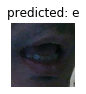

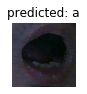

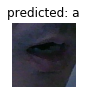

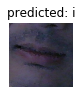

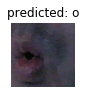

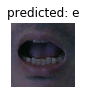

In [9]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [10]:
# パラメータを保存
PATH = './test_learned.pth'
torch.save(model_conv.state_dict(), PATH)

In [20]:
# モデル読み込み
PATH = './test_learned.pth'
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False # モデルの勾配算出をオフにする
    
num_ftrs = model_conv.fc.in_features # 全結合層の入力ノード数を取得
model_conv.fc = nn.Linear(num_ftrs,5) # 全結合層の出力ノード数を5に変更

model_conv = model_conv.to(device)

model_conv.load_state_dict(torch.load(PATH))

<All keys matched successfully>

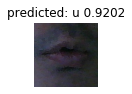

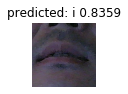

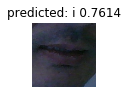

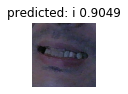

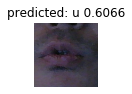

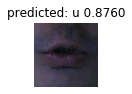

In [79]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [3]:
data_transforms = transforms.Compose([
        transforms.Resize(256), #画像を256*256にリサイズする
        #transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

In [11]:
import cv2
from PIL import Image
image_path = './mouth_data/train/a/image_0001.png'
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
data_transforms(img)

tensor([[[-0.4739, -0.4739, -0.4739,  ..., -1.2617, -1.2617, -1.2617],
         [-0.4739, -0.4739, -0.4739,  ..., -1.2617, -1.2617, -1.2617],
         [-0.4568, -0.4568, -0.4568,  ..., -1.2617, -1.2617, -1.2617],
         ...,
         [-0.5938, -0.5767, -0.5767,  ..., -1.3130, -1.3302, -1.3302],
         [-0.5767, -0.5767, -0.5596,  ..., -1.2959, -1.3130, -1.3130],
         [-0.5767, -0.5767, -0.5596,  ..., -1.2959, -1.3130, -1.3130]],

        [[-0.5651, -0.5651, -0.5651,  ..., -1.2129, -1.2129, -1.2129],
         [-0.5651, -0.5651, -0.5651,  ..., -1.2129, -1.2129, -1.2129],
         [-0.5476, -0.5476, -0.5476,  ..., -1.2129, -1.1954, -1.1954],
         ...,
         [-0.6527, -0.6352, -0.6176,  ..., -1.1954, -1.2129, -1.2129],
         [-0.6352, -0.6352, -0.6176,  ..., -1.1779, -1.1954, -1.1954],
         [-0.6352, -0.6352, -0.6176,  ..., -1.1779, -1.1954, -1.1954]],

        [[-0.0964, -0.0964, -0.0964,  ..., -0.9330, -0.9330, -0.9330],
         [-0.0964, -0.0964, -0.0964,  ..., -0